In [1]:
#@title required libraries
! pip install torchmetrics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 805.2/805.2 kB 8.1 MB/s eta 0:00:00


In [2]:
#@title download repo
! git clone https://github.com/hdspgroup/SeismicEnhancement
%cd SeismicEnhancement

Cloning into 'SeismicEnhancement'...
remote: Enumerating objects: 198, done.
remote: Counting objects: 100% (198/198), done.
remote: Compressing objects: 100% (158/158), done.
remote: Total 198 (delta 83), reused 66 (delta 21), pack-reused 0
Receiving objects: 100% (198/198), 42.37 MiB | 21.14 MiB/s, done.
Resolving deltas: 100% (83/83), done.
/content/SeismicEnhancement


In [3]:
#@title download F3 patches dataset
! gdown 1i1Ih9iVeLx5Bf5vhUuh9N_wNOZ2XB0OW
! mkdir /data
! unzip patches_f3_v4.zip -d /data

Streaming output truncated to the last 5000 lines.
  inflating: /data/patches_f3_v4/patch_3329.npy  
  inflating: /data/patches_f3_v4/patch_333.npy  
  inflating: /data/patches_f3_v4/patch_3330.npy  
  inflating: /data/patches_f3_v4/patch_3331.npy  
  inflating: /data/patches_f3_v4/patch_3332.npy  
  inflating: /data/patches_f3_v4/patch_3333.npy  
  inflating: /data/patches_f3_v4/patch_3334.npy  
  inflating: /data/patches_f3_v4/patch_3335.npy  
  inflating: /data/patches_f3_v4/patch_3336.npy  
  inflating: /data/patches_f3_v4/patch_3337.npy  
  inflating: /data/patches_f3_v4/patch_3338.npy  
  inflating: /data/patches_f3_v4/patch_3339.npy  
  inflating: /data/patches_f3_v4/patch_334.npy  
  inflating: /data/patches_f3_v4/patch_3340.npy  
  inflating: /data/patches_f3_v4/patch_3341.npy  
  inflating: /data/patches_f3_v4/patch_3342.npy  
  inflating: /data/patches_f3_v4/patch_3343.npy  
  inflating: /data/patches_f3_v4/patch_3344.npy  
  inflating: /data/patches_f3_v4/patch_3345.npy  
 

In [4]:
import os
import torch

from dataclasses import dataclass
from torchvision.utils import make_grid


from libs.utils import get_default_device
from libs.dataloader import get_dataloader, inverse_transform
from libs.diffusion.config import BaseConfig, TrainingConfig, ModelConfig

torch.Size([16, 1, 128, 128])


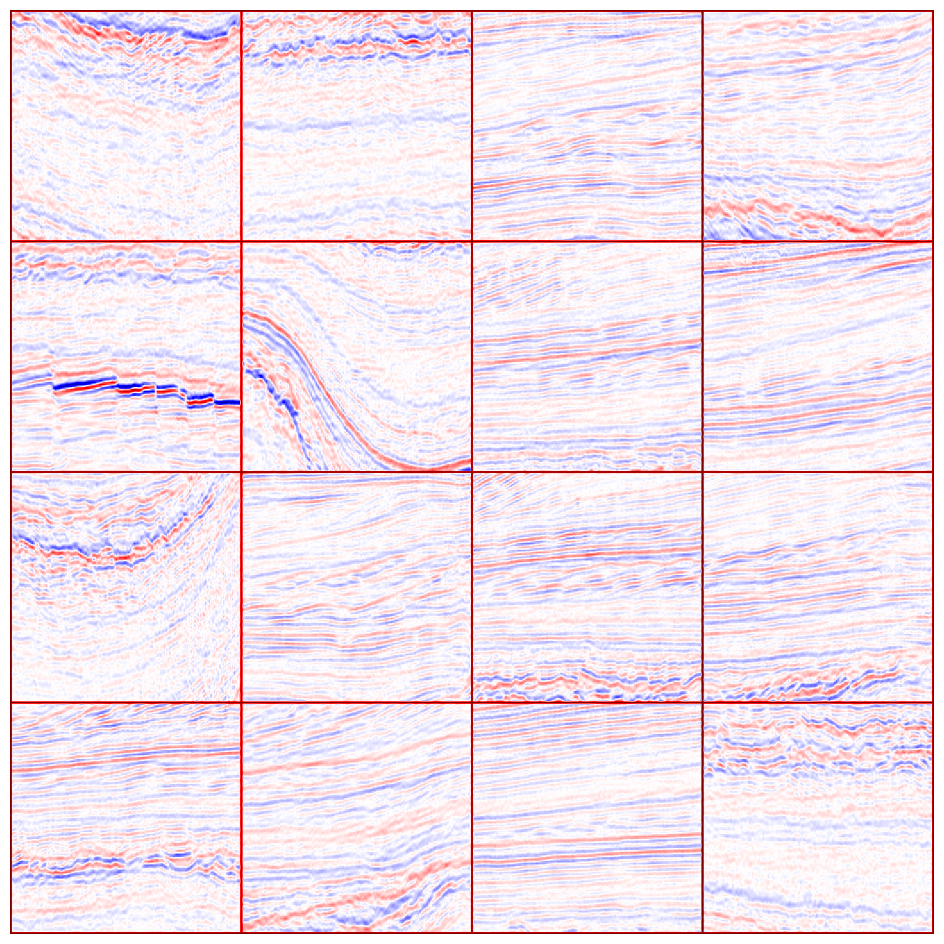

In [5]:
import matplotlib.pyplot as plt

loader = get_dataloader(
    dataset_name=BaseConfig.DATASET,
    batch_size=16,
    device='cpu',
)

plt.figure(figsize=(12, 12), facecolor='white')

for b_image in loader:
    print(b_image.shape)
    b_image = inverse_transform(b_image).cpu()
    grid_img = make_grid(b_image / 255.0, nrow=4, padding=True, pad_value=1, normalize=False)
    plt.imshow(grid_img.permute(1, 2, 0)[..., 0], cmap="seismic", vmin=0, vmax=1)
    plt.axis("off")
    break

In [7]:
from libs.variational import VAE

model_params = dict(
    in_channels=1,
    latent_dim=128
)

model = VAE(**model_params)
model.to(BaseConfig.DEVICE)

optimizer = torch.optim.Adam(model.parameters(), lr=TrainingConfig.LR)

dataloader = get_dataloader(
    dataset_name  = BaseConfig.DATASET,
    batch_size    = TrainingConfig.BATCH_SIZE,
    device        = BaseConfig.DEVICE,
    pre_load      = True,
)

# kld_weight = 0.00025
kld_weight = 0.00001

In [8]:
from tqdm import tqdm
from torchmetrics import MeanMetric

EPOCHS = TrainingConfig.NUM_EPOCHS


def train_one_epoch(model, loader, optimizer, epoch=0):

    model.train()

    loss_record = MeanMetric()

    with tqdm(total=len(loader), dynamic_ncols=True) as tq:
        tq.set_description(f"Train :: Epoch: {epoch}/{EPOCHS}")

        for batch in loader:

            real_img = batch.to(BaseConfig.DEVICE)
            tq.update(1)


            results = model(real_img)

            train_loss = model.loss_function(*results, M_N=kld_weight)
            loss = train_loss['loss']

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            loss_value = loss.detach().item()
            loss_record.update(loss_value)

            tq.set_postfix_str(s=f"Loss: {loss_value:.4f}")

        mean_loss = loss_record.compute().item()
        tq.set_postfix_str(s=f"Epoch Loss: {mean_loss:.4f}")

In [9]:
import matplotlib.pyplot as plt


def plot(output):
    plt.figure(figsize=(16, 16))

    b_image = inverse_transform(output.detach()).cpu()
    # b_image = output.detach().cpu()
    grid_img = make_grid(b_image, nrow=8, padding=True, pad_value=128, normalize=False)
    plt.imshow(grid_img.permute(1, 2, 0)[..., 0], cmap="seismic")
    plt.axis("off")
    plt.show()



for epoch in range(EPOCHS):

    train_one_epoch(model, dataloader, optimizer, epoch=epoch)

    model.eval()

    with torch.no_grad():
        output = model.sample(16, current_device=BaseConfig.DEVICE)
        plot(output)


Train :: Epoch: 0/10:   6%|▌         | 39/633 [00:43<11:10,  1.13s/it, Loss: 0.0166]


KeyboardInterrupt: ignored

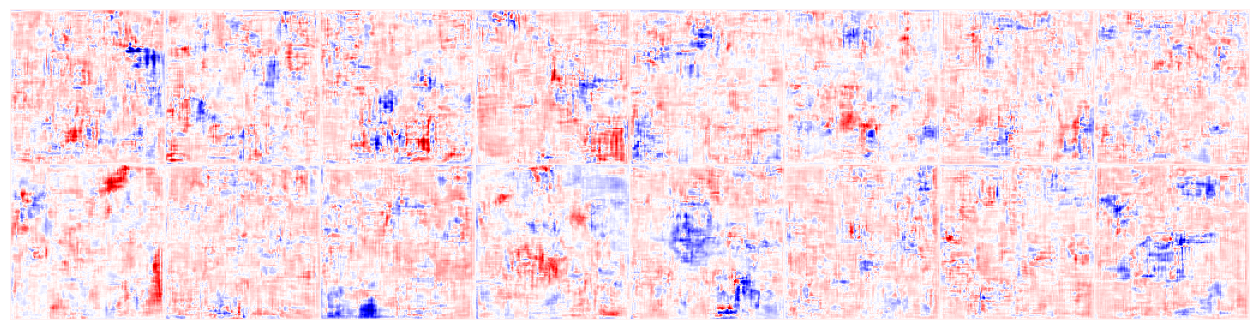

In [10]:
with torch.no_grad():
  output = model.sample(16, current_device=BaseConfig.DEVICE)
  plot(output)